In [96]:
import pandas as pd

## Data Reading

In [97]:
df = pd.read_parquet('../../data/more_processed/no2_with_traffic_and_meteo_one_station.parquet')
df['fecha'] = pd.to_datetime(df['fecha'])

## Split in train test

In [98]:
"""

I want to create a GAM model to understand the interactions for each features. My topic is about nowcasting NO2 based on meteo and traffic data. Help me.

Probably I want to use the test during 2024, and before that date, do the training. 

I have around 10 different NO2 statio, each of them with the closest traffic sensor assigned. The thing is that 
for each of them, the data could be different. Theoretically, starts 2018 and ends 2024, but there could be gaps in the data.

That's why I want to do nowcasting instead of a time series model. Do you agree? What would be the best approach to take right now given that this is my df.info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269056 entries, 0 to 3269055
Data columns (total 32 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id_no2            object        
 1   year              int64         
 2   month             int64         
 3   day               int64         
 4   hour              int64         
 5   no2_value         float64       
 6   validacion        object        
 7   fecha             datetime64[ns]
 8   altitud           int64         
 9   nom_tipo          object        
 10  longitud          float64       
 11  latitud           float64       
 12  id_trafico        object        
 13  distance_m        float64       
 14  latitud_no2       float64       
 15  longitud_no2      float64       
 16  latitud_trafico   float64       
 17  longitud_trafico  float64       
 18  intensidad        float64       
 19  carga             float64       
 20  ocupacion         float64       
 21  vmed              float64       
 22  latitud_meteo     float64       
 23  longitud_meteo    float64       
 24  d2m               float32       
 25  t2m               float32       
 26  ssr               float32       
 27  ssrd              float32       
 28  u10               float32       
 29  v10               float32       
 30  sp                float32       
 31  tp                float32       
dtypes: datetime64[ns](1), float32(8), float64(14), int64(5), object(4)
memory usage: 698.3+ MB



"""

"\n\nI want to create a GAM model to understand the interactions for each features. My topic is about nowcasting NO2 based on meteo and traffic data. Help me.\n\nProbably I want to use the test during 2024, and before that date, do the training. \n\nI have around 10 different NO2 statio, each of them with the closest traffic sensor assigned. The thing is that \nfor each of them, the data could be different. Theoretically, starts 2018 and ends 2024, but there could be gaps in the data.\n\nThat's why I want to do nowcasting instead of a time series model. Do you agree? What would be the best approach to take right now given that this is my df.info:\n\n<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 3269056 entries, 0 to 3269055\nData columns (total 32 columns):\n #   Column            Dtype         \n---  ------            -----         \n 0   id_no2            object        \n 1   year              int64         \n 2   month             int64         \n 3   day               int64   

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f, te
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

Missing values:
 id_no2              0
year                0
month               0
day                 0
hour                0
no2_value           0
validacion          0
fecha               0
altitud             0
nom_tipo            0
longitud            0
latitud             0
id_trafico          0
distance_m          0
latitud_no2         0
longitud_no2        0
latitud_trafico     0
longitud_trafico    0
intensidad          0
carga               0
ocupacion           0
vmed                0
latitud_meteo       0
longitud_meteo      0
d2m                 0
t2m                 0
ssr                 0
ssrd                0
u10                 0
v10                 0
sp                  0
tp                  0
dtype: int64


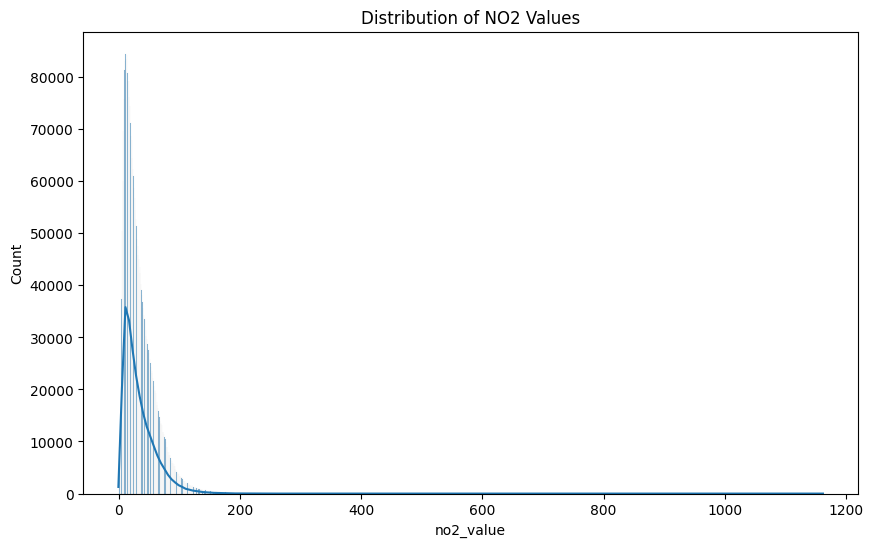

In [100]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Create cyclical features for time variables
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

# Examine NO2 distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['no2_value'].dropna(), kde=True)
plt.title('Distribution of NO2 Values')
plt.show()

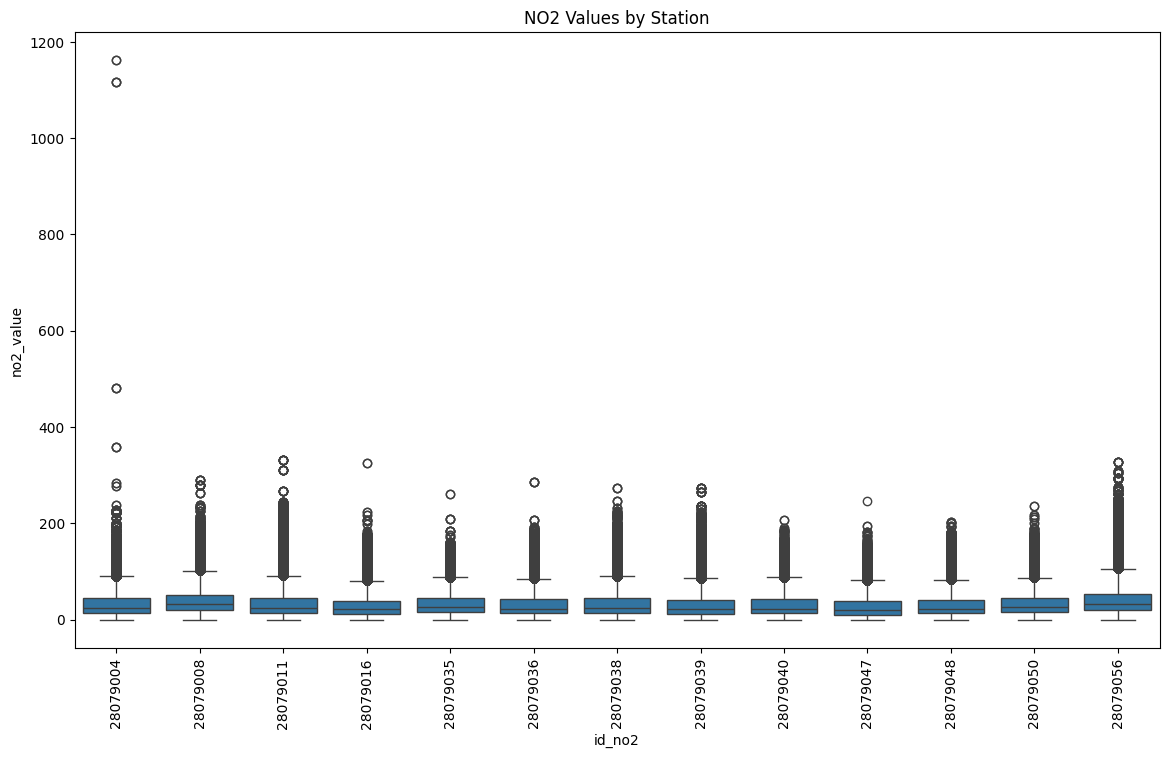

In [101]:
# Look at NO2 values by station
plt.figure(figsize=(14, 8))
sns.boxplot(x='id_no2', y='no2_value', data=df)
plt.xticks(rotation=90)
plt.title('NO2 Values by Station')
plt.show()

In [102]:
COLUMNS_FOR_OUTLIERS = [
    'no2_value',         # concentración de NO₂ (target, revisar cuidadosamente)
    'intensidad',        # intensidad del tráfico
    'carga',             # carga del tráfico
    'ocupacion',         # ocupación
    'vmed',              # velocidad media
    'd2m', 't2m',        # temperatura del punto de rocío y temperatura 2m
    'ssr', 'ssrd',       # shortwave radiation
    'u10', 'v10',        # componentes del viento
    'sp',                # presión
    'tp',                # precipitación
]

import pandas as pd

def remove_outliers_iqr(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """Elimina outliers usando el método del IQR (interquartile range)."""
    filtered_df = df.copy()
    for col in columns:
        if col in filtered_df.columns:
            Q1 = filtered_df[col].quantile(0.25)
            Q3 = filtered_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]
    return filtered_df


def remove_outliers_zscore(df: pd.DataFrame, columns: list[str], threshold: float = 3.0) -> pd.DataFrame:
    """Elimina outliers usando el método del z-score (valores con desviación estándar alta)."""
    from scipy.stats import zscore
    filtered_df = df.copy()
    zscores = filtered_df[columns].apply(zscore)
    condition = (zscores.abs() < threshold).all(axis=1)
    return filtered_df[condition]


def remove_outliers_quantiles(df: pd.DataFrame, columns: list[str], lower_q=0.01, upper_q=0.99) -> pd.DataFrame:
    """Elimina outliers basados en percentiles extremos."""
    filtered_df = df.copy()
    for col in columns:
        if col in filtered_df.columns:
            lower = filtered_df[col].quantile(lower_q)
            upper = filtered_df[col].quantile(upper_q)
            filtered_df = filtered_df[(filtered_df[col] >= lower) & (filtered_df[col] <= upper)]
    return filtered_df


def filter_outliers(df: pd.DataFrame, method: str = 'iqr') -> pd.DataFrame:
    if method == 'iqr':
        return remove_outliers_iqr(df, COLUMNS_FOR_OUTLIERS)
    elif method == 'zscore':
        return remove_outliers_zscore(df, COLUMNS_FOR_OUTLIERS)
    elif method == 'quantiles':
        return remove_outliers_quantiles(df, COLUMNS_FOR_OUTLIERS)
    else:
        raise ValueError(f"Método '{method}' no reconocido. Usa: 'iqr', 'zscore' o 'quantiles'.")

In [ ]:
# Filter for a single station
station_id = '28079008'
df_single = df[df['id_no2'] == station_id].copy()

df_single = filter_outliers(df_single, method='iqr')  # Puedes cambiar a 'zscore' o 'quantiles'

# Check the data size for this station
print(f"Number of records for station {station_id}: {len(df_single)}")
print(f"Date range: {df_single['fecha'].min()} to {df_single['fecha'].max()}")

Number of records for station 28079008: 226275
Date range: 2018-01-01 00:00:00 to 2024-12-01 00:00:00


In [104]:
# Data preprocessing
# Convert fecha to datetime if not already
df_single['fecha'] = pd.to_datetime(df_single['fecha'])

# Create cyclical features for time variables
df_single['hour_sin'] = np.sin(2 * np.pi * df_single['hour']/24)
df_single['hour_cos'] = np.cos(2 * np.pi * df_single['hour']/24)
df_single['month_sin'] = np.sin(2 * np.pi * df_single['month']/12)
df_single['month_cos'] = np.cos(2 * np.pi * df_single['month']/12)
df_single['day_sin'] = np.sin(2 * np.pi * df_single['fecha'].dt.weekday / 7)
df_single['day_cos'] = np.cos(2 * np.pi * df_single['fecha'].dt.weekday / 7)

In [105]:
df_single['day']/31

338339    1.000000
338340    1.000000
338341    1.000000
338342    1.000000
338343    1.000000
            ...   
614768    0.967742
614769    0.967742
614770    0.967742
614771    0.967742
614772    0.967742
Name: day, Length: 226275, dtype: float64

In [106]:
# Split by year for training/testing
train_df = df_single[df_single['year'] < 2024].copy()
test_df = df_single[df_single['year'] >= 2024].copy()

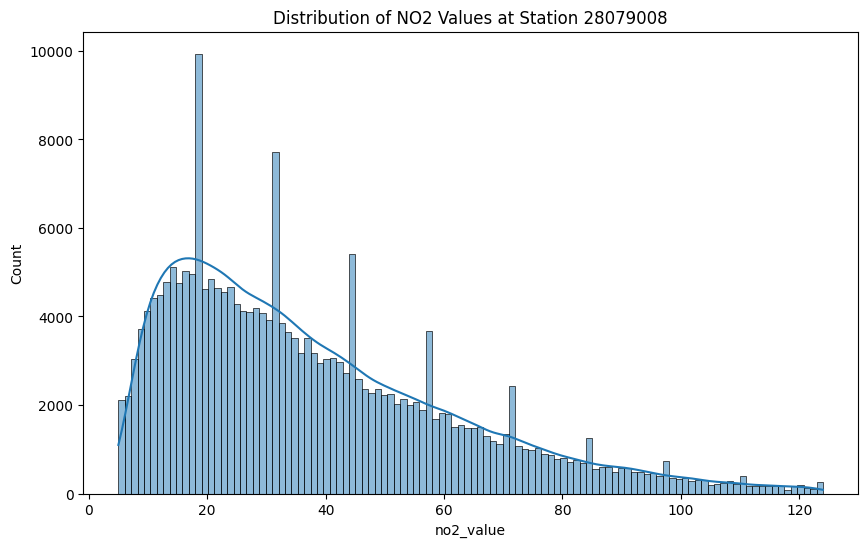

In [107]:
# Select features for the model
features = [
    # Temporal cyclical features
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    # Traffic features
    'intensidad', 'carga', 'ocupacion', 'vmed',
    # Meteorological features
    'd2m', 't2m', 'ssr', 'ssrd', 'u10', 'v10', 'sp', 'tp'
]

# Data exploration for this station
plt.figure(figsize=(10, 6))
sns.histplot(df_single['no2_value'].dropna(), kde=True)
plt.title(f'Distribution of NO2 Values at Station {station_id}')
plt.show()

In [113]:
df_single[features]

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,intensidad,carga,ocupacion,vmed,d2m,t2m,ssr,ssrd,u10,v10,sp,tp
338339,-2.449294e-16,1.0,-2.449294e-16,1.000000,0.000000,1.00000,149.25,10.629816,0.852596,0.0,274.032562,277.393158,3331750.0,3895668.0,2.331177,0.028870,94138.9375,0.001036
338340,-2.449294e-16,1.0,-2.449294e-16,1.000000,0.000000,1.00000,256.25,6.539512,1.222439,0.0,274.032562,277.393158,3331750.0,3895668.0,2.331177,0.028870,94138.9375,0.001036
338341,-2.449294e-16,1.0,-2.449294e-16,1.000000,0.000000,1.00000,237.25,11.444679,1.924131,0.0,274.032562,277.393158,3331750.0,3895668.0,2.331177,0.028870,94138.9375,0.001036
338342,-2.449294e-16,1.0,-2.449294e-16,1.000000,0.000000,1.00000,319.50,17.334116,1.888106,0.0,274.032562,277.393158,3331750.0,3895668.0,2.331177,0.028870,94138.9375,0.001036
338343,-2.449294e-16,1.0,-2.449294e-16,1.000000,0.000000,1.00000,146.00,17.325342,0.724315,0.0,274.032562,277.393158,3331750.0,3895668.0,2.331177,0.028870,94138.9375,0.001036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614768,-2.449294e-16,1.0,-5.000000e-01,0.866025,-0.781831,0.62349,270.00,20.000000,3.000000,0.0,278.750549,279.489044,7851006.0,9216524.0,-0.289169,-1.552353,94445.1250,0.000000
614769,-2.449294e-16,1.0,-5.000000e-01,0.866025,-0.781831,0.62349,1562.75,42.713966,10.250680,0.0,278.750549,279.489044,7851006.0,9216524.0,-0.289169,-1.552353,94445.1250,0.000000
614770,-2.449294e-16,1.0,-5.000000e-01,0.866025,-0.781831,0.62349,466.25,24.015013,2.996247,0.0,278.750549,279.489044,7851006.0,9216524.0,-0.289169,-1.552353,94445.1250,0.000000
614771,-2.449294e-16,1.0,-5.000000e-01,0.866025,-0.781831,0.62349,984.25,46.462535,7.098552,0.0,278.750549,279.489044,7851006.0,9216524.0,-0.289169,-1.552353,94445.1250,0.000000


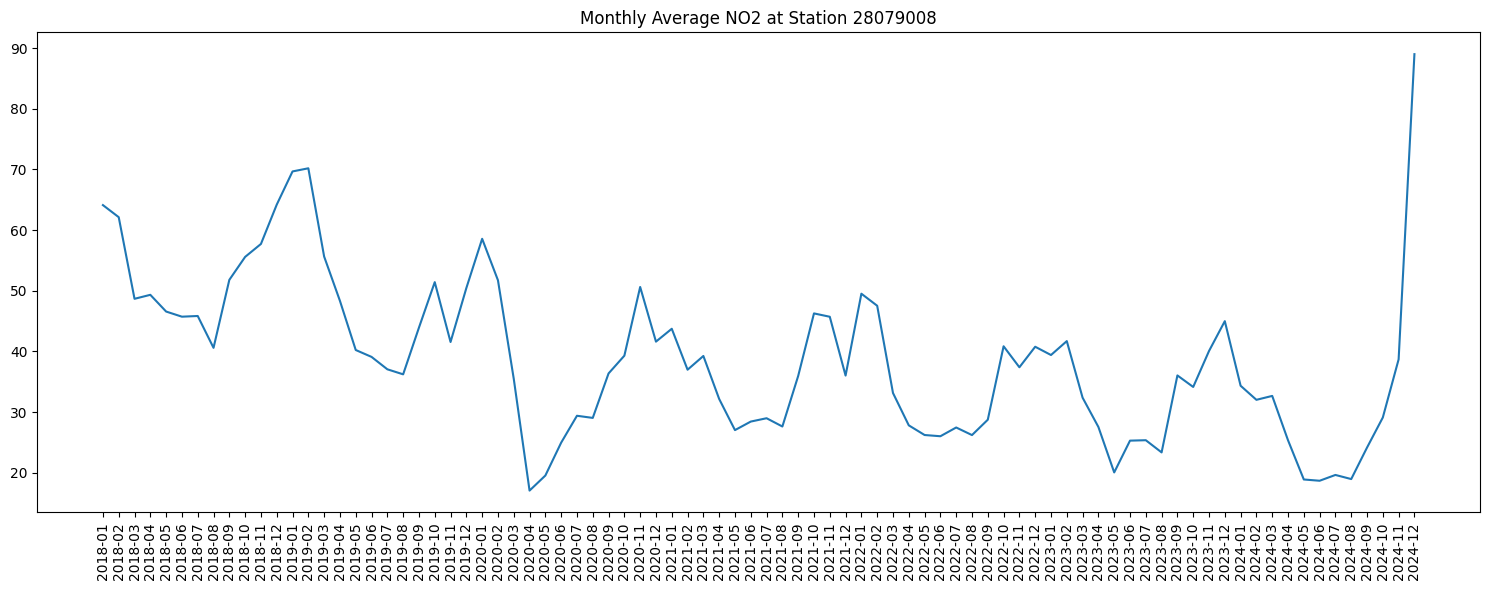

In [108]:


# Monthly patterns
df_single['month_year'] = df_single['fecha'].dt.to_period('M')
monthly_avg = df_single.groupby('month_year')['no2_value'].mean().reset_index()
monthly_avg['month_year'] = monthly_avg['month_year'].astype(str)

plt.figure(figsize=(15, 6))
plt.plot(monthly_avg['month_year'], monthly_avg['no2_value'])
plt.xticks(rotation=90)
plt.title(f'Monthly Average NO2 at Station {station_id}')
plt.tight_layout()
plt.show()

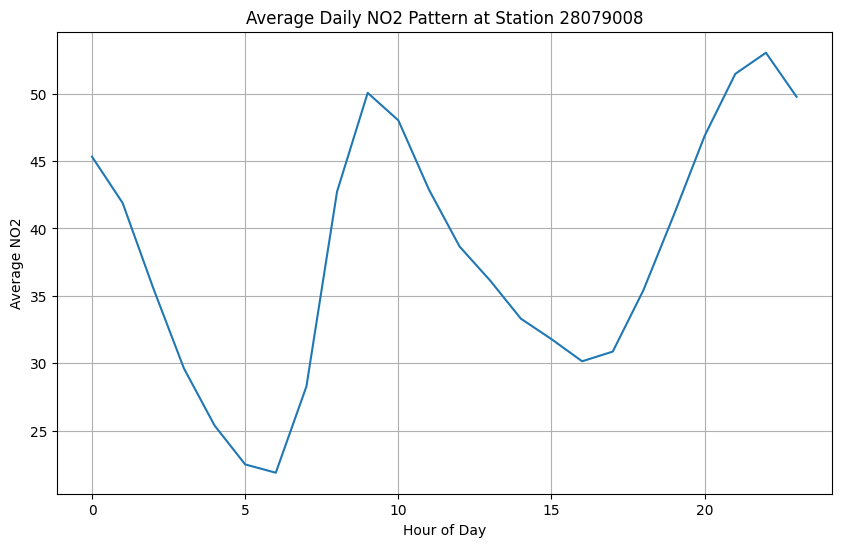

In [109]:
# Daily patterns
df_single['hour_avg'] = df_single.groupby('hour')['no2_value'].transform('mean')
plt.figure(figsize=(10, 6))
plt.plot(range(24), df_single['hour_avg'].unique()[:24])
plt.title(f'Average Daily NO2 Pattern at Station {station_id}')
plt.xlabel('Hour of Day')
plt.ylabel('Average NO2')
plt.grid(True)
plt.show()

In [110]:
# Prepare training data
X_train = train_df[features].copy()
y_train = train_df['no2_value'].copy()

X_test = test_df[features].copy()
y_test = test_df['no2_value'].copy()

# Handle missing values
#X_train = X_train.fillna(X_train.mean())
#y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

# Create a GAM model
gam = LinearGAM(
    s(0) + s(1) +                  # Hour cyclical terms
    s(2) + s(3) +                  # Month cyclical terms
    s(4) + s(5) +                  # Day cyclical terms
    s(6, n_splines=5) +           # intensidad
    s(7, n_splines=5) +           # carga
    s(8, n_splines=5) +           # ocupacion
    s(9, n_splines=5) +           # vmed
    s(10, n_splines=5) +          # d2m (2m dewpoint temperature)
    s(11, n_splines=5) +          # t2m (2m temperature)
    s(12, n_splines=5) +          # ssr (surface solar radiation)
    s(13, n_splines=5) +          # ssrd (surface solar radiation downwards)
    s(14, n_splines=5) +          # u10 (10m u-wind component)
    s(15, n_splines=5) +          # v10 (10m v-wind component)
    s(16, n_splines=5) +          # sp (surface pressure)
    s(17, n_splines=5)            # tp (total precipitation)
)

# Fit the model
gam.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + intercept,
   tol=0.0001, verbose=False)

In [111]:
X_test = test_df[features]
y_test = test_df['no2_value']
y_pred = gam.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


RMSE: 405.1849520893852
R²: -0.12488203188176983


In [112]:
2stop

SyntaxError: invalid decimal literal (386111058.py, line 1)

In [17]:
# # Print summary
# print(gam.summary())

# # Check feature significance for this station
# print("Feature significance for station", station_id)
# for i, p_value in enumerate(gam.statistics_['p_values']):
#     if i < len(features):
#         print(f"{features[i]}: p-value = {p_value:.6f}")

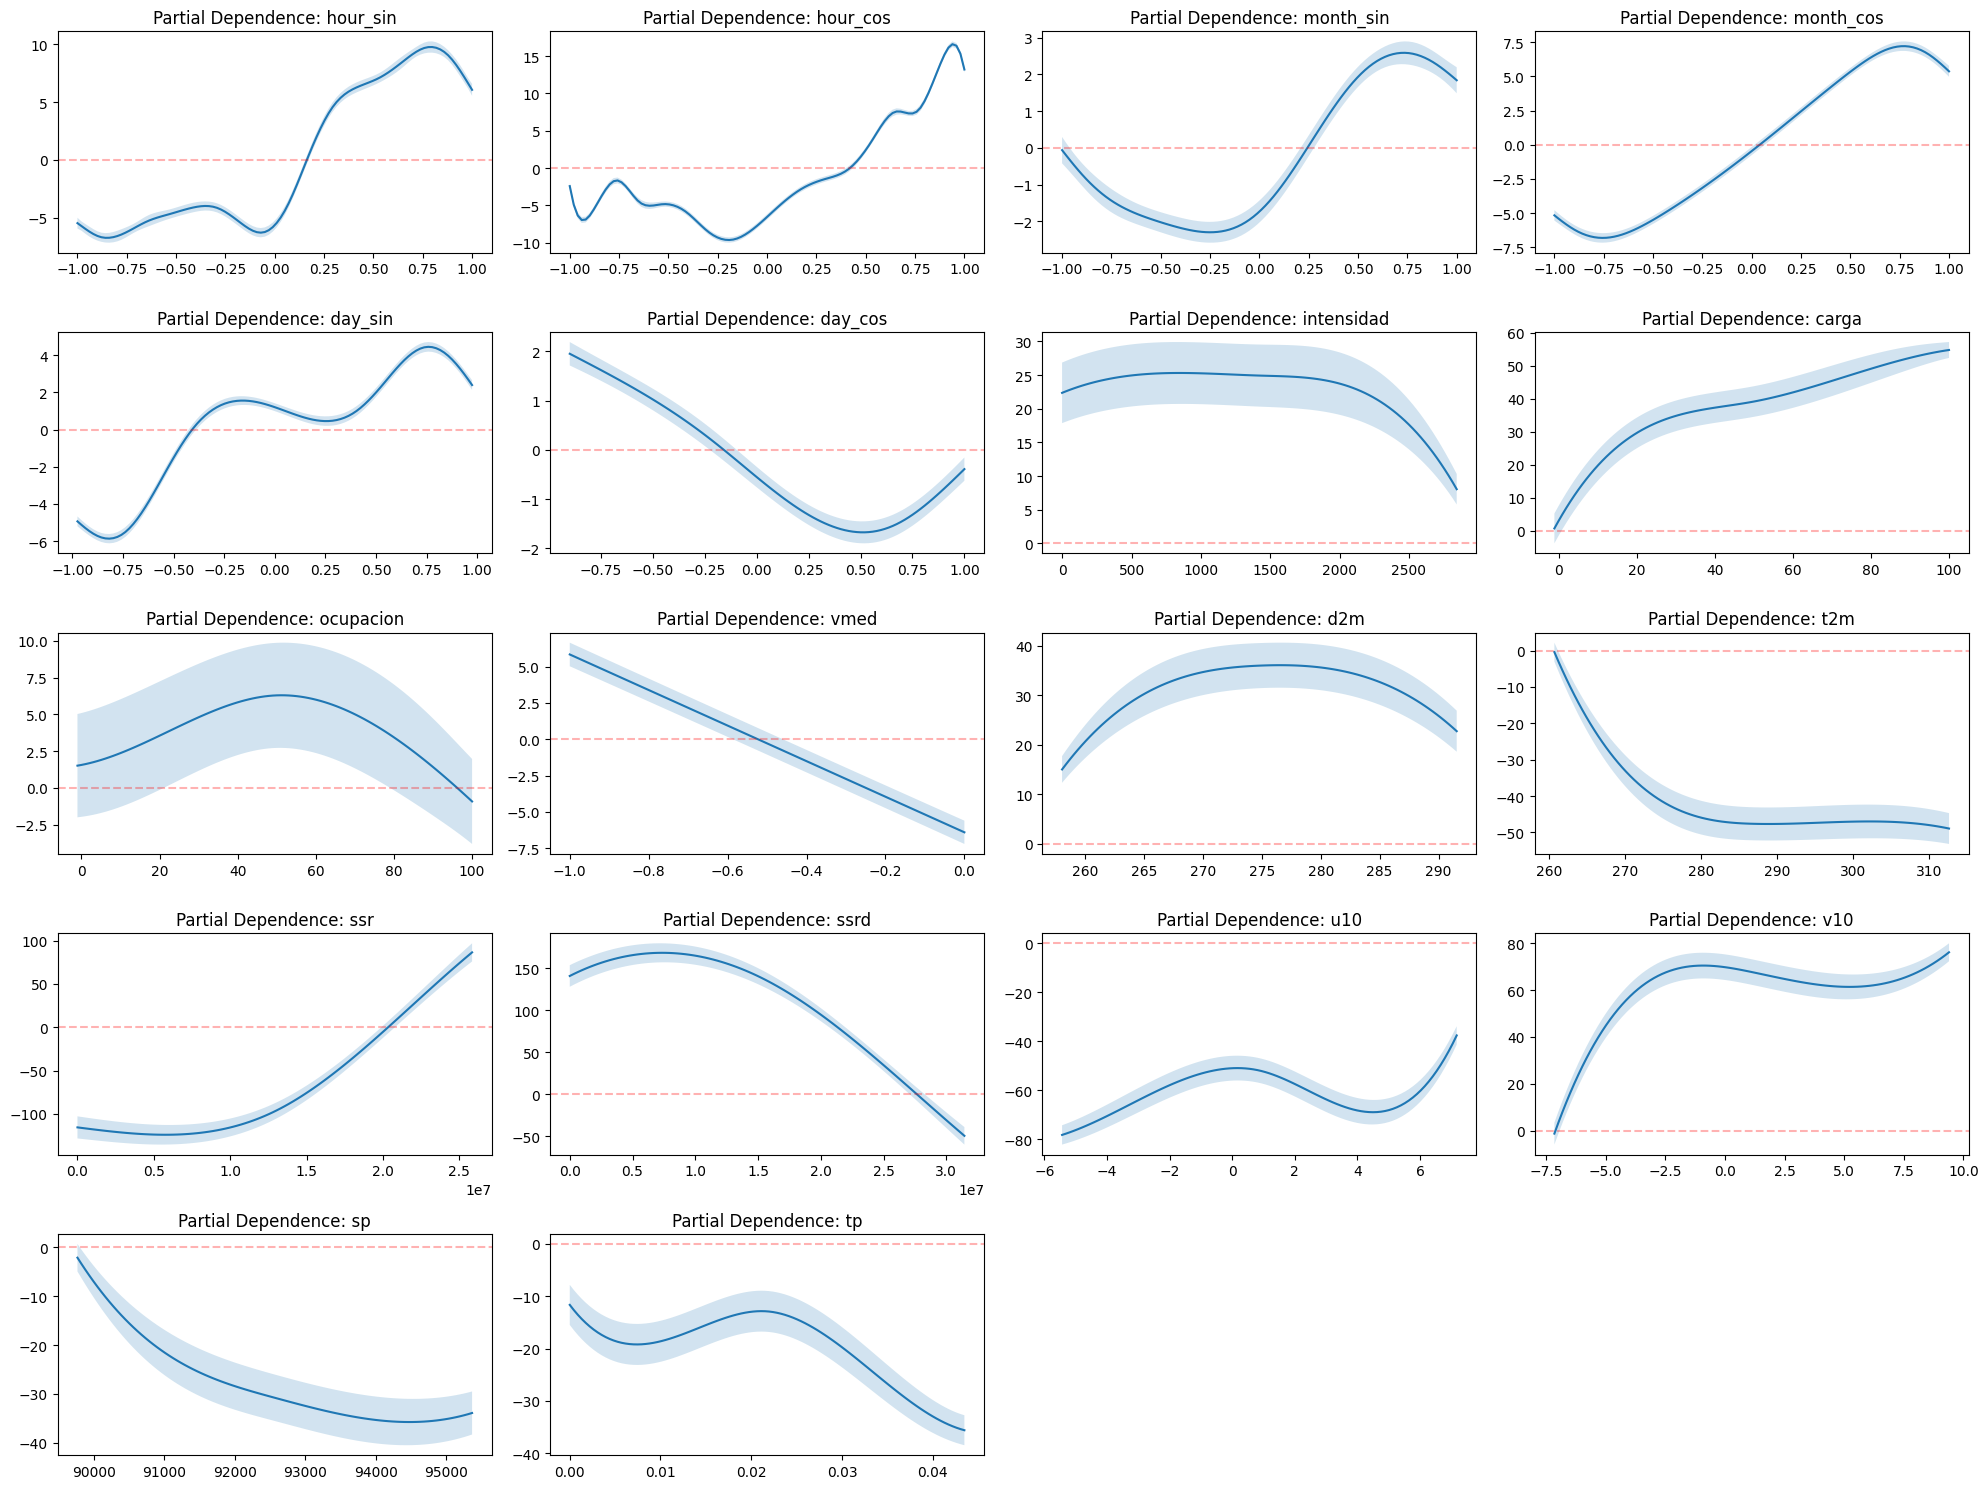

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hour_effects.append(float(pdep_sin + pdep_cos))


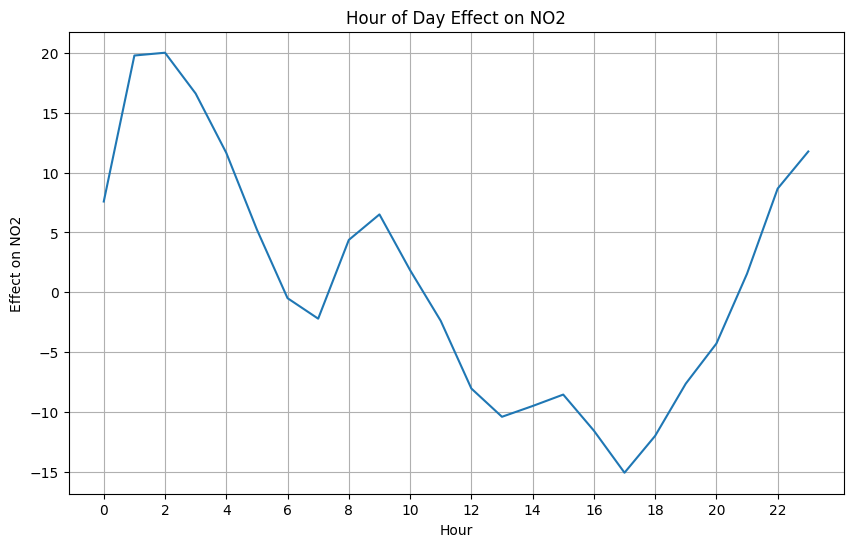

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  month_effects.append(float(pdep_sin + pdep_cos))


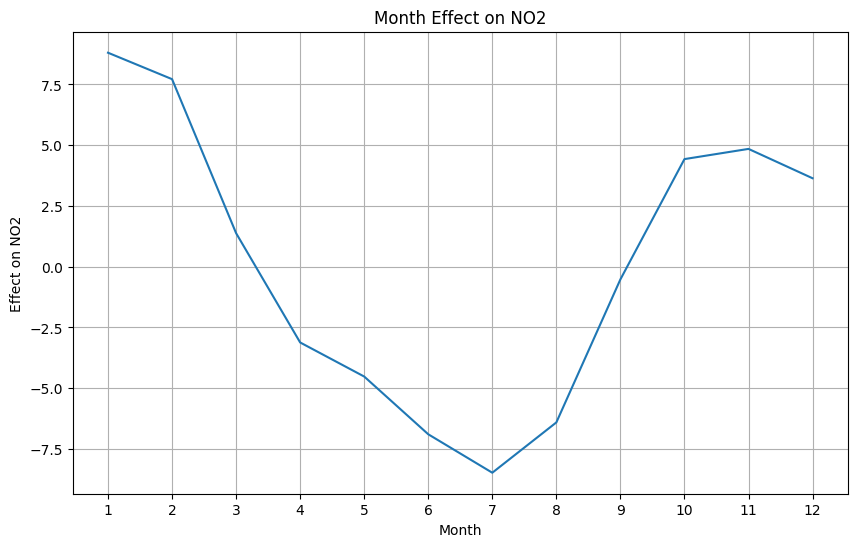

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_effect = train_df.groupby('dir_bin')['no2_value'].mean().reset_index()
/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:97: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = train_df.pivot_table(


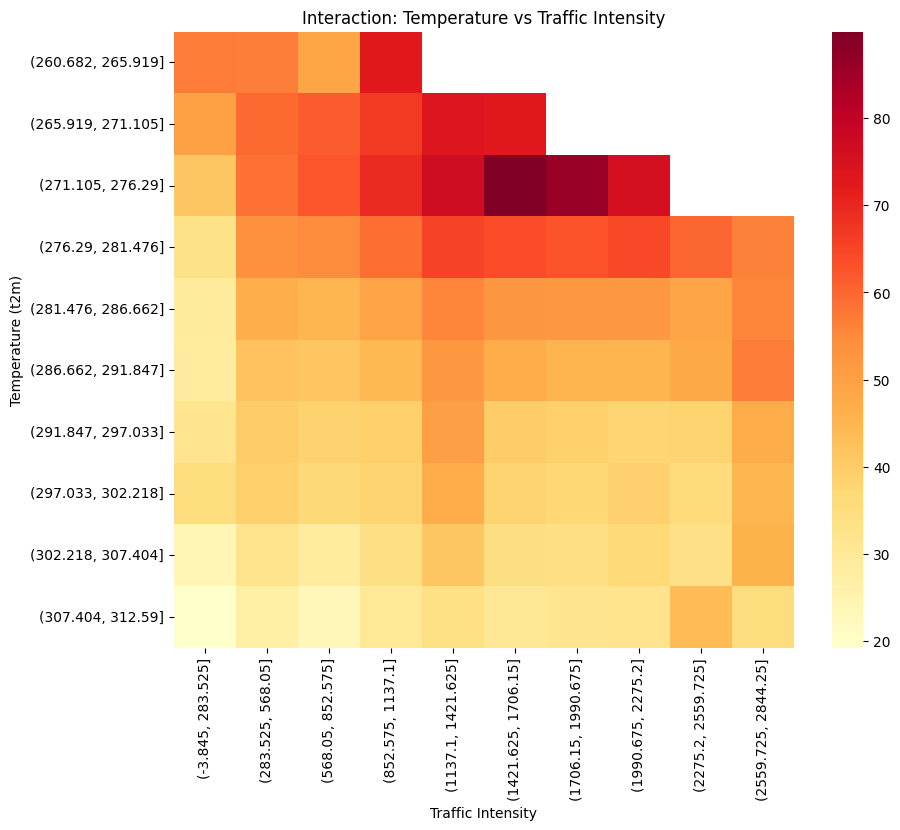

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:112: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = train_df.pivot_table(


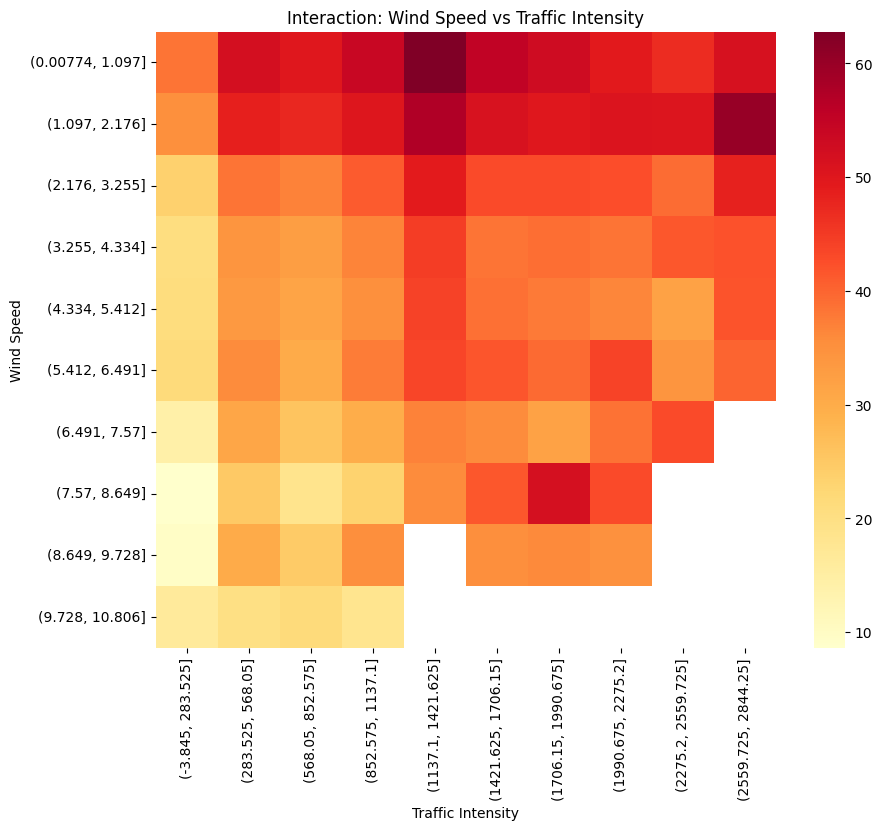

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_32578/1861823995.py:127: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = train_df.pivot_table(


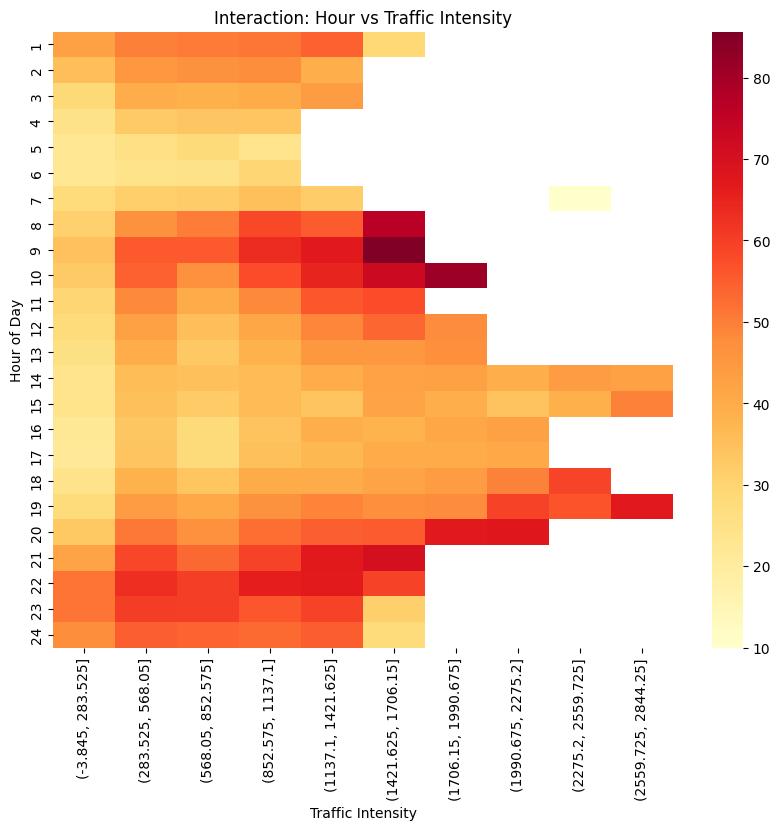

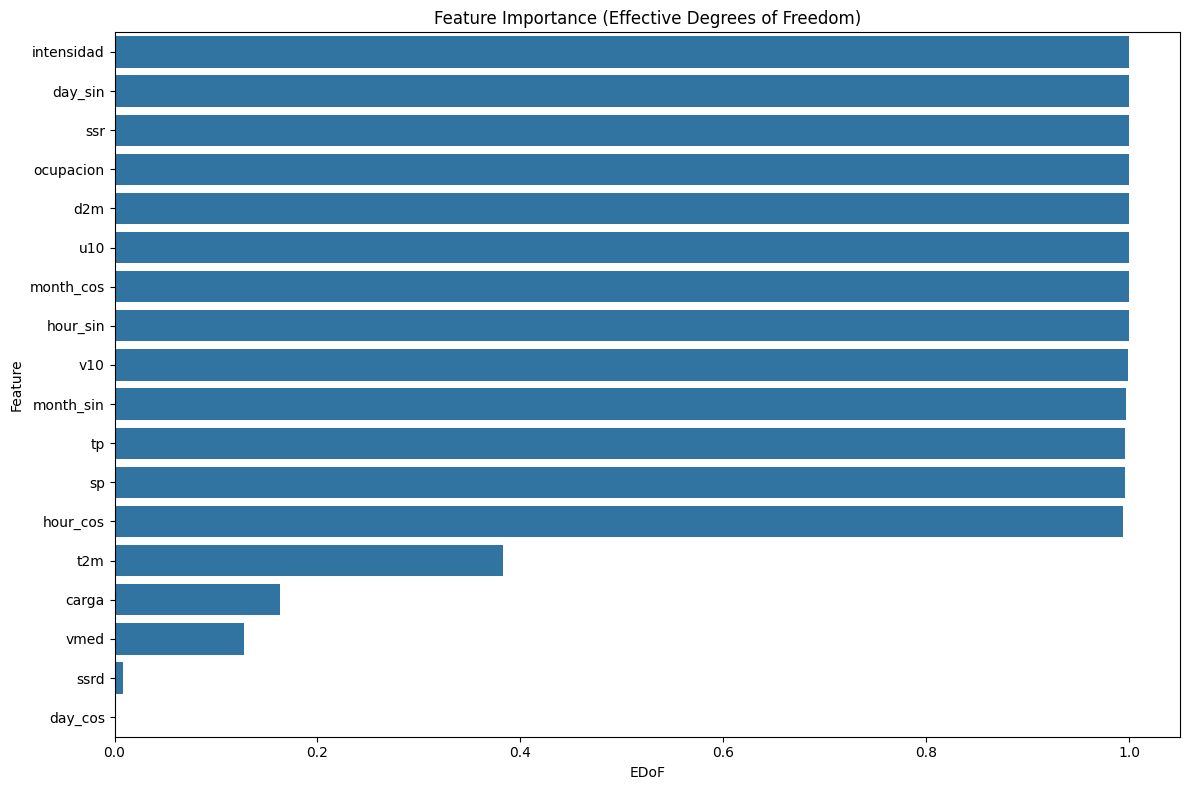

Model Interpretation Summary for Station 28079008:
Pseudo R-Squared: 0.3853
Top 5 most important features by EDoF:
  1. intensidad (EDoF: 1.00)
  2. day_sin (EDoF: 1.00)
  3. ssr (EDoF: 1.00)
  4. ocupacion (EDoF: 1.00)
  5. d2m (EDoF: 1.00)


In [18]:
# 4. Model Visualization and Interpretation

# Plot the partial dependence plots for each feature
plt.figure(figsize=(20, 15))
feature_names = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'intensidad', 'carga', 'ocupacion', 'vmed',
    'd2m', 't2m', 'ssr', 'ssrd', 'u10', 'v10', 'sp', 'tp'
]

for i, feature in enumerate(feature_names):
    plt.subplot(5, 4, i+1)
    XX = gam.generate_X_grid(term=i)
    
    # Handle both cases: when method returns tuple or single value
    try:
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
        plt.plot(XX[:, i], pdep)
        plt.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    except ValueError:
        pdep = gam.partial_dependence(term=i, X=XX)
        plt.plot(XX[:, i], pdep)
    
    plt.title(f'Partial Dependence: {feature}')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.3)  # Add a horizontal line at y=0
plt.tight_layout()
plt.savefig('partial_dependence_plots.png', dpi=300)
plt.show()

# For temporal features, convert to more interpretable units
# Hour effect
hours = np.linspace(0, 23, 24)
hour_effects = []
for hour in hours:
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    # Generate the grid for these features
    XX_hour = np.zeros((1, len(feature_names)))
    XX_hour[0, 0] = hour_sin
    XX_hour[0, 1] = hour_cos
    # Calculate partial effect
    pdep_sin = gam.partial_dependence(term=0, X=XX_hour)
    pdep_cos = gam.partial_dependence(term=1, X=XX_hour)
    hour_effects.append(float(pdep_sin + pdep_cos))

plt.figure(figsize=(10, 6))
plt.plot(hours, hour_effects)
plt.title('Hour of Day Effect on NO2')
plt.xlabel('Hour')
plt.ylabel('Effect on NO2')
plt.xticks(range(0, 24, 2))
plt.grid(True)
plt.savefig('hour_effect.png', dpi=300)
plt.show()

# Month effect
months = np.linspace(1, 12, 12)
month_effects = []
for month in months:
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    # Generate the grid for these features
    XX_month = np.zeros((1, len(feature_names)))
    XX_month[0, 2] = month_sin
    XX_month[0, 3] = month_cos
    # Calculate partial effect
    pdep_sin = gam.partial_dependence(term=2, X=XX_month)
    pdep_cos = gam.partial_dependence(term=3, X=XX_month)
    month_effects.append(float(pdep_sin + pdep_cos))

plt.figure(figsize=(10, 6))
plt.plot(months, month_effects)
plt.title('Month Effect on NO2')
plt.xlabel('Month')
plt.ylabel('Effect on NO2')
plt.xticks(range(1, 13))
plt.grid(True)
plt.savefig('month_effect.png', dpi=300)
plt.show()

# Wind direction visualization
# First, create a wind direction variable from u10 and v10
# Using the training data
train_df['wind_direction'] = (270 - np.degrees(np.arctan2(train_df['v10'], train_df['u10']))) % 360
train_df['wind_speed'] = np.sqrt(train_df['u10']**2 + train_df['v10']**2)

# Group by wind direction (in bins) and calculate average NO2
dir_bins = np.arange(0, 361, 10)  # 10-degree bins
train_df['dir_bin'] = pd.cut(train_df['wind_direction'], bins=dir_bins, labels=dir_bins[:-1])
wind_effect = train_df.groupby('dir_bin')['no2_value'].mean().reset_index()


# Examine feature interactions
# Create interaction plots for important pairs
# 1. Traffic intensity vs Temperature
plt.figure(figsize=(10, 8))
heatmap_data = train_df.pivot_table(
    values='no2_value', 
    index=pd.cut(train_df['t2m'], bins=10), 
    columns=pd.cut(train_df['intensidad'], bins=10), 
    aggfunc='mean'
)
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.title('Interaction: Temperature vs Traffic Intensity')
plt.xlabel('Traffic Intensity')
plt.ylabel('Temperature (t2m)')
plt.savefig('temp_traffic_interaction.png', dpi=300)
plt.show()

# 2. Wind speed vs Traffic intensity
plt.figure(figsize=(10, 8))
heatmap_data = train_df.pivot_table(
    values='no2_value', 
    index=pd.cut(train_df['wind_speed'], bins=10), 
    columns=pd.cut(train_df['intensidad'], bins=10), 
    aggfunc='mean'
)
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.title('Interaction: Wind Speed vs Traffic Intensity')
plt.xlabel('Traffic Intensity')
plt.ylabel('Wind Speed')
plt.savefig('wind_traffic_interaction.png', dpi=300)
plt.show()

# 3. Hour of day vs Traffic intensity
plt.figure(figsize=(10, 8))
heatmap_data = train_df.pivot_table(
    values='no2_value', 
    index='hour', 
    columns=pd.cut(train_df['intensidad'], bins=10), 
    aggfunc='mean'
)
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False)
plt.title('Interaction: Hour vs Traffic Intensity')
plt.xlabel('Traffic Intensity')
plt.ylabel('Hour of Day')
plt.savefig('hour_traffic_interaction.png', dpi=300)
plt.show()

# Create a relative feature importance plot (based on EDoF values)
edof_values = gam.statistics_['edof_per_coef'][:len(feature_names)]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'EDoF': edof_values
})
feature_importance = feature_importance.sort_values('EDoF', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='EDoF', y='Feature', data=feature_importance)
plt.title('Feature Importance (Effective Degrees of Freedom)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Model interpretation summary
print("Model Interpretation Summary for Station 28079008:")
print(f"Pseudo R-Squared: {gam.statistics_['pseudo_r2']['explained_deviance']:.4f}")
print("Top 5 most important features by EDoF:")
for i in range(5):
    feature = feature_importance.iloc[i]
    print(f"  {i+1}. {feature['Feature']} (EDoF: {feature['EDoF']:.2f})")

In [19]:
test_february_two_days = test_df[(test_df['fecha'] > '2024-02-01') & (test_df['fecha'] < '2024-02-04')]

X_test = test_february_two_days[features].copy()
y_test = test_february_two_days['no2_value'].copy()

# Predicciones del modelo
y_pred = gam.predict(X_test)

In [20]:
len(y_test)

355

In [21]:
te

<function pygam.terms.te(*args, **kwargs)>

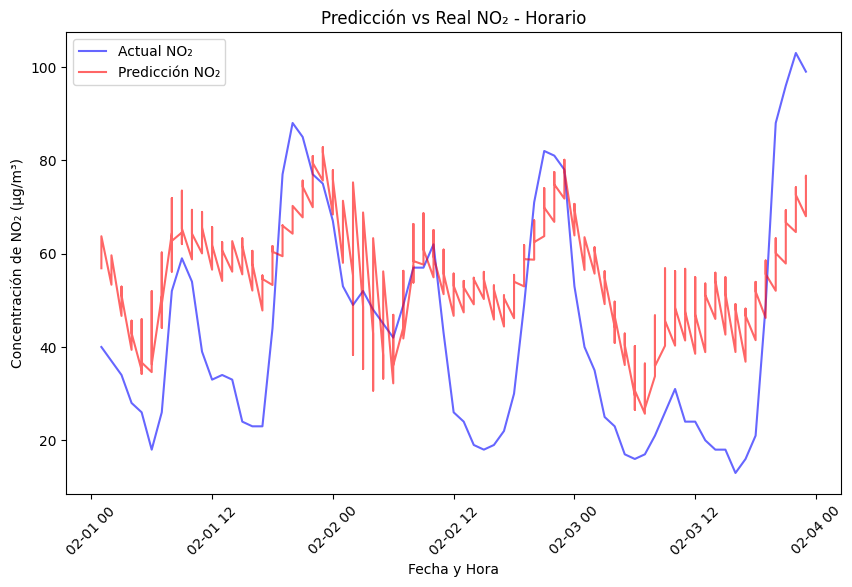

In [22]:
import matplotlib.pyplot as plt

# Graficar valores reales vs. predicciones
plt.figure(figsize=(10, 6))
plt.plot(test_february_two_days['fecha'], y_test, label='Actual NO₂', color='blue', alpha=0.6)
plt.plot(test_february_two_days['fecha'], y_pred, label='Predicción NO₂', color='red', alpha=0.6)
plt.title('Predicción vs Real NO₂ - Horario')
plt.xlabel('Fecha y Hora')
plt.ylabel('Concentración de NO₂ (µg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


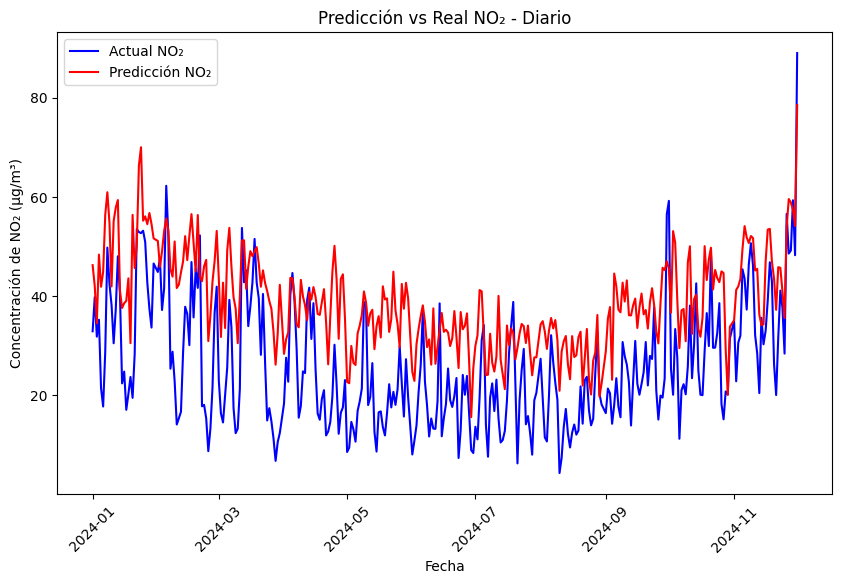

In [ ]:


# Agrupar por día
test_df['fecha_dia'] = test_df['fecha'].dt.date
y_pred_daily = pd.DataFrame({'fecha_dia': test_df['fecha_dia'], 'pred': y_pred})
y_actual_daily = pd.DataFrame({'fecha_dia': test_df['fecha_dia'], 'actual': y_test})

# Agrupar por día y calcular la media
y_pred_daily_mean = y_pred_daily.groupby('fecha_dia').mean()
y_actual_daily_mean = y_actual_daily.groupby('fecha_dia').mean()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(y_actual_daily_mean.index, y_actual_daily_mean['actual'], label='Actual NO₂', color='blue')
plt.plot(y_pred_daily_mean.index, y_pred_daily_mean['pred'], label='Predicción NO₂', color='red')
plt.title('Predicción vs Real NO₂ - Diario')
plt.xlabel('Fecha')
plt.ylabel('Concentración de NO₂ (µg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

